In [51]:
import numpy as np
import pandas as pd

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 5, 4

import warnings
warnings.filterwarnings('ignore')

In [53]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn import metrics

In [54]:
df = pd.read_csv('UCI_Credit_Card.csv')

## Filter some data according to the previous EDA section

In [55]:
dataset = df.copy()

In [56]:
dataset.rename(columns={'PAY_0':'PAY_1', 'default.payment.next.month':'default_payment'}, inplace=True)
dataset['EDUCATION'] = dataset['EDUCATION'].map({0:0, 1:1, 2:2, 3:3, 4:3, 5:3, 6:3})
X_train, X_test, y_train, y_test = train_test_split(dataset.iloc[:,1:24], dataset['default_payment'], test_size=0.2, random_state=30)

In [57]:
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
12207,190000.0,1,1,1,42,-1,-1,-1,-1,-1,...,7517.0,2168.0,4918.0,5300.0,3706.0,7523.0,2168.0,5300.0,3000.0,0.0
11452,50000.0,1,2,2,39,1,2,0,0,0,...,49987.0,19663.0,16769.0,16550.0,0.0,2600.0,650.0,752.0,596.0,578.0
10404,210000.0,2,2,2,30,0,0,0,2,2,...,50999.0,51884.0,50926.0,54404.0,2150.0,5000.0,2020.0,0.0,4500.0,2000.0
29997,30000.0,1,2,2,37,4,3,2,-1,0,...,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0
9753,80000.0,2,1,2,30,0,0,0,0,0,...,73027.0,74215.0,75865.0,77448.0,3500.0,3500.0,3000.0,3000.0,3000.0,3000.0


## Scaling the dataset

In [58]:
scaler = StandardScaler()
scaler.fit(X_train)
X_scaled = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

## Building the training model

In [59]:
cv_split  = ShuffleSplit(n_splits = 10, test_size = 0.25, random_state = 0)

In [60]:
random_state = 20

classifiers = []
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(GaussianNB())
classifiers.append(SVC(random_state=random_state))

In [61]:
cv_results = []
cv_means = []
cv_std = []

for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_scaled, y_train, scoring = 'accuracy', cv = cv_split, n_jobs=-1))

for cv_result in cv_results:
    cv_means.append(round(cv_result.mean(), 4) * 100)
    cv_std.append(round(cv_result.std(), 4) * 100)

cv_res = pd.DataFrame({"ACC_Means":cv_means,"ACC_errors": cv_std,"Algorithm":["LDA", "LR", "KNN", "DT", "RF", "NB", "SVC"]})

In [62]:
cv_res

,ACC_Means,ACC_errors,Algorithm
0,81.16,0.53,LDA
1,81.04,0.52,LR
2,78.81,0.44,KNN
3,72.44,0.60,DT
4,80.40,0.54,RF
5,66.69,5.49,NB
6,81.64,0.41,SVC


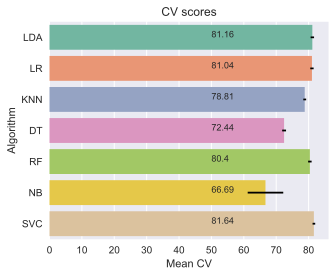

In [99]:
g = sns.barplot("ACC_Means","Algorithm",data = cv_res, orient = "h", **{'xerr':cv_std},  palette="Set2")
g.set_xlabel("Mean CV")
g.set_title("CV scores")


for index, row  in cv_res.iterrows():
    plt.text(x = 50 , y = index, s = round(row.ACC_Means,4), size = 9)
plt.figure(figsize=(6,5))
plt.show()

take all algorithms to the next step

## Parameter Optimization

In [64]:
kfold = StratifiedKFold(n_splits=10)

In [65]:
def LearningCurve(X, y, model, cv, title):
    
    train_sizes, train_scores, val_scores = learning_curve(model, X, y, cv = cv,
                                                           n_jobs = -1, train_sizes = np.linspace(.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std   = np.std(train_scores, axis = 1)
    val_scores_mean  = np.mean(val_scores, axis = 1)
    val_scores_std   = np.std(val_scores, axis = 1)
    
    plt.title('Learning Curve %s'%(title))
    plt.grid(True)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    

    plt.legend(loc = "best")
     

### Linear Discriminant Analysis

In [66]:
LDA = LinearDiscriminantAnalysis()

LDA_params = {'solver': ['svd', 'lsqr', 'eigen']}

LDA_gs = GridSearchCV(LDA, param_grid = LDA_params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

LDA_gs.fit(X_scaled, y_train)

LDA_final = LDA_gs.best_estimator_

print("\nBest Estimatot:", LDA_gs.best_estimator_,
          "\nBest Score:", LDA_gs.best_score_,
          "\nBest parameters:", LDA_gs.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits

Best Estimatot: LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001) 
Best Score: 0.8165416666666667 
Best parameters: {'solver': 'eigen'}


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.7s finished


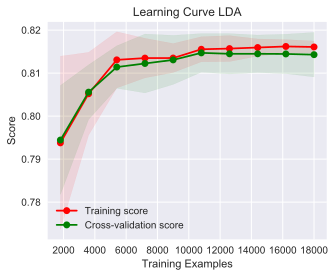

In [67]:
LearningCurve(X_scaled, y_train, LDA_final, cv_split, 'LDA')

### Logistic Regression

In [68]:
LR = LogisticRegression()

LR_params = {'penalty': ['l1', 'l2'],
             'C': [0.001, 0.01, 0.1, 1, 10]
             }

LR_gs = GridSearchCV(LR, param_grid = LR_params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

LR_gs.fit(X_scaled, y_train)

LR_final = LR_gs.best_estimator_

print("\nBest Estimatot:", LR_gs.best_estimator_,
          "\nBest Score:", LR_gs.best_score_,
          "\nBest parameters:", LR_gs.best_params_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.9s finished



Best Estimatot: LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 
Best Score: 0.8106666666666666 
Best parameters: {'C': 0.1, 'penalty': 'l2'}


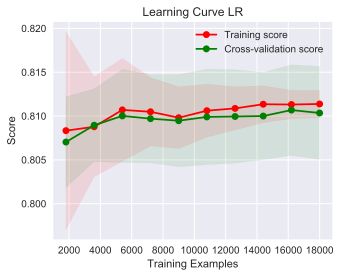

In [69]:
LearningCurve(X_scaled, y_train, LR_final, cv_split, 'LR')

### K-Nearest Neighbors

In [70]:
KNN = KNeighborsClassifier()

KNN_params = {'n_neighbors': [3, 5, 7, 9, 11, 13],
              'weights': ['uniform', 'distance']}


KNN_gs = GridSearchCV(KNN, param_grid = KNN_params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

KNN_gs.fit(X_scaled, y_train)

KNN_final = KNN_gs.best_estimator_

print("\nBest Estimatot:", KNN_gs.best_estimator_,
          "\nBest Score:", KNN_gs.best_score_,
          "\nBest parameters:", KNN_gs.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.4min



Best Estimatot: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform') 
Best Score: 0.8076666666666666 
Best parameters: {'n_neighbors': 13, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed: 25.2min finished


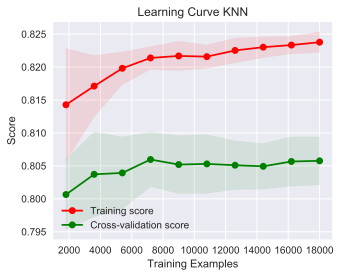

In [71]:
LearningCurve(X_scaled, y_train, KNN_final, cv_split, 'KNN')

### Decision Tree

In [72]:
DT = DecisionTreeClassifier()

DT_params = {'criterion' : ['entropy', 'gini'],
             'min_samples_split': [2, 3, 10],
             'min_samples_leaf': [3, 10]}


DT_gs = GridSearchCV(DT, param_grid = DT_params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

DT_gs.fit(X_scaled, y_train)

DT_final = DT_gs.best_estimator_

print("\nBest Estimatot:", DT_gs.best_estimator_,
          "\nBest Score:", DT_gs.best_score_,
          "\nBest parameters:", DT_gs.best_params_)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   27.3s finished



Best Estimatot: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best') 
Best Score: 0.7763333333333333 
Best parameters: {'criterion': 'gini', 'min_samples_leaf': 10, 'min_samples_split': 2}


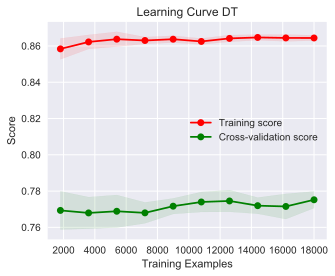

In [73]:
LearningCurve(X_scaled, y_train, DT_final, cv_split, 'DT')

### Random Forest

In [74]:
RF = RandomForestClassifier()

RF_params = {'oob_score': [True],
             'max_depth': [None],
             'bootstrap': [True],
             'n_estimators': [100, 300, 500],
             'min_samples_leaf': [2, 4],
             'min_samples_split': [5]}


RF_gs = GridSearchCV(RF, param_grid = RF_params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

RF_gs.fit(X_scaled, y_train)

RF_final = RF_gs.best_estimator_

print("\nBest Estimatot:", RF_gs.best_estimator_,
          "\nBest Score:", RF_gs.best_score_,
          "\nBest parameters:", RF_gs.best_params_)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  7.1min finished



Best Estimatot: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False) 
Best Score: 0.818125 
Best parameters: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 300, 'oob_score': True}


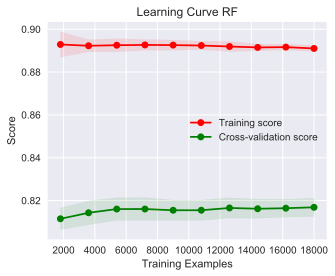

In [75]:
LearningCurve(X_scaled, y_train, RF_final, cv_split, 'RF')

### Naive Bayes

In [76]:
NB = GaussianNB()

NB_params = {}

NB_gs = GridSearchCV(NB, param_grid = NB_params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

NB_gs.fit(X_scaled, y_train)

NB_final = NB_gs.best_estimator_

print("\nBest Estimatot:", NB_gs.best_estimator_,
          "\nBest Score:", NB_gs.best_score_,
          "\nBest parameters:", NB_gs.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.1s finished



Best Estimatot: GaussianNB(priors=None) 
Best Score: 0.6745 
Best parameters: {}


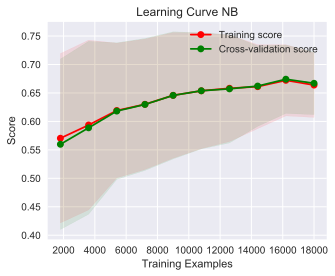

In [77]:
LearningCurve(X_scaled, y_train, NB_final, cv_split, 'NB')

### Support Vector Machine

In [78]:
SVM = SVC(probability=True)

SVM_params = {'C': [0.01, 0.1, 1]}

SVM_gs = GridSearchCV(SVM, param_grid = SVM_params, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

SVM_gs.fit(X_scaled, y_train)

SVM_final = SVM_gs.best_estimator_

print("\nBest Estimatot:", SVM_gs.best_estimator_,
          "\nBest Score:", SVM_gs.best_score_,
          "\nBest parameters:", SVM_gs.best_params_)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 30.3min finished



Best Estimatot: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 
Best Score: 0.8180833333333334 
Best parameters: {'C': 1}


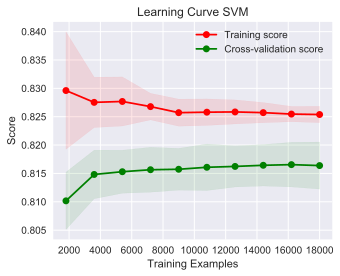

In [79]:
LearningCurve(X_scaled, y_train, SVM_final, cv_split, 'SVM')

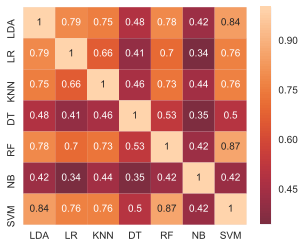

In [80]:
LDA_test_series = pd.Series(LDA_final.predict(X_scaled_test), name="LDA")
LR_test_series = pd.Series(LR_final.predict(X_scaled_test), name="LR")
KNN_test_series = pd.Series(KNN_final.predict(X_scaled_test), name="KNN")
DT_test_series = pd.Series(DT_final.predict(X_scaled_test), name="DT")
RF_test_series = pd.Series(RF_final.predict(X_scaled_test), name="RF")
NB_test_series = pd.Series(NB_final.predict(X_scaled_test), name="NB")
SVM_test_series = pd.Series(SVM_final.predict(X_scaled_test), name="SVM")

ensemble_results = pd.concat([LDA_test_series,LR_test_series,KNN_test_series,DT_test_series, 
                              RF_test_series,NB_test_series,SVM_test_series],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True, center=0)

### Voting Classifier

In [100]:
# all
voting_soft1 = VotingClassifier(estimators=[('LDA', LDA_final), ('LR', LR_final), ('KNN', KNN_final), ('DT', DT_final)
                                          , ('RF', RF_final), ('NB', NB_final), ('SVC', SVM_final)], voting='soft', n_jobs=-1)
voting_soft1.fit(X_scaled, y_train)




VotingClassifier(estimators=[('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), ('LR', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_cl...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [101]:
# all except NB
voting_soft2 = VotingClassifier(estimators=[('LDA', LDA_final), ('LR', LR_final), ('KNN', KNN_final), ('DT', DT_final)
                                          , ('RF', RF_final), ('SVC', SVM_final)], voting='soft', n_jobs=-1)
voting_soft2.fit(X_scaled, y_train)



VotingClassifier(estimators=[('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), ('LR', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_cl...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

In [102]:
# all except DT, NB
voting_soft3 = VotingClassifier(estimators=[('LDA', LDA_final), ('LR', LR_final), ('KNN', KNN_final), 
                                            ('RF', RF_final), ('SVC', SVM_final)], voting='soft', n_jobs=-1)
voting_soft3.fit(X_scaled, y_train)



VotingClassifier(estimators=[('LDA', LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='eigen', store_covariance=False, tol=0.0001)), ('LR', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_cl...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='soft', weights=None)

### Model evaluation

In [103]:
y_LDA_predict_train = LDA_final.predict(X_scaled)
y_LDA_predict_test = LDA_final.predict(X_scaled_test)

y_LR_predict_train = LR_final.predict(X_scaled)
y_LR_predict_test = LR_final.predict(X_scaled_test)

y_KNN_predict_train = KNN_final.predict(X_scaled)
y_KNN_predict_test = KNN_final.predict(X_scaled_test)

y_DT_predict_train = DT_final.predict(X_scaled)
y_DT_predict_test = DT_final.predict(X_scaled_test)

y_RF_predict_train = RF_final.predict(X_scaled)
y_RF_predict_test = RF_final.predict(X_scaled_test)

y_NB_predict_train = NB_final.predict(X_scaled)
y_NB_predict_test = NB_final.predict(X_scaled_test)

y_SVM_predict_train = SVM_final.predict(X_scaled)
y_SVM_predict_test = SVM_final.predict(X_scaled_test)

y_VC1_predict_train = voting_soft1.predict(X_scaled)
y_VC1_predict_test = voting_soft1.predict(X_scaled_test)

y_VC2_predict_train = voting_soft2.predict(X_scaled)
y_VC2_predict_test = voting_soft2.predict(X_scaled_test)

y_VC3_predict_train = voting_soft3.predict(X_scaled)
y_VC3_predict_test = voting_soft3.predict(X_scaled_test)

In [104]:
#prob version for AUC
y_LDA_predict_train_prob = LDA_final.predict_proba(X_scaled)[:,1]
y_LDA_predict_test_prob = LDA_final.predict_proba(X_scaled_test)[:,1]

y_LR_predict_train_prob = LR_final.predict_proba(X_scaled)[:,1]
y_LR_predict_test_prob = LR_final.predict_proba(X_scaled_test)[:,1]

y_KNN_predict_train_prob = KNN_final.predict_proba(X_scaled)[:,1]
y_KNN_predict_test_prob = KNN_final.predict_proba(X_scaled_test)[:,1]

y_DT_predict_train_prob = DT_final.predict_proba(X_scaled)[:,1]
y_DT_predict_test_prob = DT_final.predict_proba(X_scaled_test)[:,1]

y_RF_predict_train_prob = RF_final.predict_proba(X_scaled)[:,1]
y_RF_predict_test_prob = RF_final.predict_proba(X_scaled_test)[:,1]

y_NB_predict_train_prob = NB_final.predict_proba(X_scaled)[:,1]
y_NB_predict_test_prob = NB_final.predict_proba(X_scaled_test)[:,1]

y_SVM_predict_train_prob = SVM_final.predict_proba(X_scaled)[:,1]
y_SVM_predict_test_prob = SVM_final.predict_proba(X_scaled_test)[:,1]

y_VC1_predict_train_prob = voting_soft1.predict_proba(X_scaled)[:,1]
y_VC1_predict_test_prob = voting_soft1.predict_proba(X_scaled_test)[:,1]

y_VC2_predict_train_prob = voting_soft2.predict_proba(X_scaled)[:,1]
y_VC2_predict_test_prob = voting_soft2.predict_proba(X_scaled_test)[:,1]

y_VC3_predict_train_prob = voting_soft3.predict_proba(X_scaled)[:,1]
y_VC3_predict_test_prob = voting_soft3.predict_proba(X_scaled_test)[:,1]



In [105]:
algorithm_list = ['LDA', 'LR', 'KNN', 'DT', 'RF', 'NB', 'SVM', 'VC1', 'VC2', 'VC3']

In [116]:
predict_train = [y_LDA_predict_train, y_LR_predict_train, y_KNN_predict_train, y_DT_predict_train, y_RF_predict_train,
                y_NB_predict_train, y_SVM_predict_train, y_VC1_predict_train, y_VC2_predict_train, y_VC3_predict_train]
train_accuracy_scores = []
train_type1_scores = []
train_type2_scores = []
train_precision_scores = []
train_recall_scores = []
train_f1_scores = []

for train in predict_train:
    train_accuracy_scores.append(accuracy_score(y_train, train))
    
    tn, fp, fn, tp = confusion_matrix(y_train, train).ravel()
    train_type1_scores.append(fp/(fp+tn))
    train_type2_scores.append(fn/(tp+fn))
    train_precision_scores.append(precision_score(y_train, train))
    train_recall_scores.append(recall_score(y_train, train))
    train_f1_scores.append(f1_score(y_train, train))



In [117]:
predict_train_prob = [y_LDA_predict_train_prob, y_LR_predict_train_prob, y_KNN_predict_train_prob, 
                      y_DT_predict_train_prob, y_RF_predict_train_prob,y_NB_predict_train_prob, 
                      y_SVM_predict_train_prob, y_VC1_predict_train_prob, y_VC2_predict_train_prob, y_VC3_predict_train_prob]
train_auc_scores = []
for train in predict_train_prob:
    fpr, tpr, thresholds = metrics.roc_curve(y_train, train)
    train_auc_scores.append(metrics.auc(fpr, tpr))
    #train_auc_scores.append(roc_auc_score(y_train, train))

In [118]:
predict_test = [y_LDA_predict_test, y_LR_predict_test, y_KNN_predict_test, y_DT_predict_test, y_RF_predict_test,
                y_NB_predict_test, y_SVM_predict_test, y_VC1_predict_test, y_VC2_predict_test, y_VC3_predict_test]
test_accuracy_scores = []
test_type1_scores = []
test_type2_scores = []
test_precision_scores = []
test_recall_scores = []
test_f1_scores = []

for test in predict_test:
    test_accuracy_scores.append(accuracy_score(y_test, test))
    
    tn, fp, fn, tp = confusion_matrix(y_test, test).ravel()
    test_type1_scores.append(fp/(fp+tn))
    test_type2_scores.append(fn/(tp+fn))
    test_precision_scores.append(precision_score(y_test, test))
    test_recall_scores.append(recall_score(y_test, test))
    test_f1_scores.append(f1_score(y_test, test))
    


In [119]:
predict_test_prob = [y_LDA_predict_test_prob, y_LR_predict_test_prob, y_KNN_predict_test_prob, 
                      y_DT_predict_test_prob, y_RF_predict_test_prob,y_NB_predict_test_prob, 
                      y_SVM_predict_test_prob, y_VC1_predict_test_prob, y_VC2_predict_test_prob, y_VC3_predict_test_prob]
test_auc_scores = []
for test in predict_test_prob:
    test_auc_scores.append(roc_auc_score(y_test, test))

In [120]:
model_result_train = pd.DataFrame({"Algorithm":algorithm_list, "Accuracy Score": train_accuracy_scores,
                             "Type I error":train_type1_scores, "Type II error":train_type2_scores,
                             "Precision":train_precision_scores, "Recall":train_recall_scores, "F1": train_f1_scores,
                             "AUC":train_auc_scores})
model_result_train = model_result_train[['Algorithm', 'Accuracy Score', 'Type I error', 'Type II error', 'Precision', 'Recall', 'F1', 'AUC']]

In [121]:
model_result_train

,Algorithm,Accuracy Score,Type I error,Type II error,Precision,Recall,F1,AUC
0,LDA,0.817042,0.048107,0.652596,0.674646,0.347404,0.458636,0.719322
1,LR,0.810875,0.026976,0.753829,0.723778,0.246171,0.367387,0.724980
2,KNN,0.823500,0.047410,0.626074,0.693694,0.373926,0.485922,0.829038
3,DT,0.864042,0.054703,0.418939,0.753086,0.581061,0.655983,0.924769
4,RF,0.891958,0.010512,0.447703,0.937837,0.552297,0.695192,0.979904
5,NB,0.674125,0.330312,0.310422,0.374784,0.689578,0.485630,0.737464
6,SVM,0.823750,0.042636,0.641576,0.707074,0.358424,0.475706,0.790337
7,VC1,0.838250,0.045693,0.565932,0.731738,0.434068,0.544900,0.893070
8,VC2,0.839167,0.030891,0.613373,0.782313,0.386627,0.517500,0.926967
9,VC3,0.832125,0.034431,0.632611,0.753929,0.367389,0.494035,0.901854


In [122]:
model_result_test = pd.DataFrame({"Algorithm":algorithm_list, "Accuracy Score": test_accuracy_scores,
                             "Type I error":test_type1_scores, "Type II error":test_type2_scores,
                             "Precision":test_precision_scores, "Recall":test_recall_scores, "F1": test_f1_scores,
                             "AUC":test_auc_scores})
model_result_test = model_result_test[['Algorithm', 'Accuracy Score', 'Type I error', 'Type II error', 'Precision', 'Recall', 'F1', 'AUC']]

In [123]:
model_result_test

,Algorithm,Accuracy Score,Type I error,Type II error,Precision,Recall,F1,AUC
0,LDA,0.816667,0.055744,0.652886,0.628531,0.347114,0.447236,0.715808
1,LR,0.813167,0.031793,0.757410,0.674620,0.242590,0.356856,0.720088
2,KNN,0.812667,0.061891,0.648986,0.606469,0.351014,0.444664,0.732092
3,DT,0.769833,0.123993,0.620905,0.453782,0.379095,0.413090,0.704071
4,RF,0.821000,0.058711,0.621685,0.636483,0.378315,0.474560,0.779071
5,NB,0.670500,0.336583,0.303432,0.359936,0.696568,0.474621,0.731395
6,SVM,0.822000,0.050445,0.647426,0.655072,0.352574,0.458418,0.728197
7,VC1,0.819167,0.066130,0.602964,0.619976,0.397036,0.484070,0.762485
8,VC2,0.819333,0.051505,0.656006,0.644737,0.343994,0.448627,0.763196
9,VC3,0.818333,0.050021,0.666147,0.644578,0.333853,0.439877,0.758727


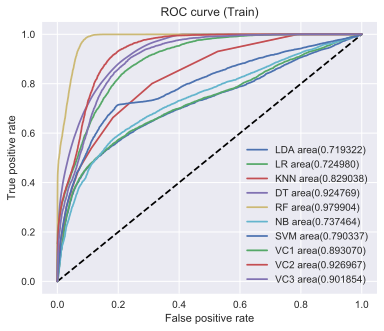

In [124]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'k--')
for index, val  in enumerate(predict_train_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y_train, val)
    plt.plot(fpr, tpr, label='{0} area({1:0.6f})'
             ''.format(algorithm_list[index], metrics.auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (Train)')
plt.legend(loc='best')
plt.show()

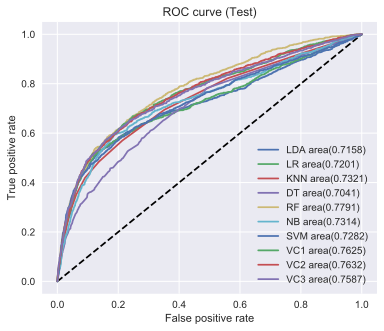

In [125]:
plt.figure(figsize=(6,5))
plt.plot([0, 1], [0, 1], 'k--')
for index, val  in enumerate(predict_test_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y_test, val)
    plt.plot(fpr, tpr, label='{0} area({1:0.4f})'
             ''.format(algorithm_list[index], metrics.auc(fpr, tpr)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (Test)')
plt.legend(loc='best')
plt.show()

#### Ref. https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling